### Notebook creado por **Guillermo Grande Santi**

#  Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import GridSearchCV, cross_val_score
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sentence_transformers import SentenceTransformer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import nltk
import re
import string
import spacy
import contractions

import shap


c:\Users\guigr\anaconda3\envs\tfm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carga de datos inicial

In [ ]:
# Cargar datos de Kaggle
df_fake = pd.read_csv("Datasets/Fake.csv") # Noticias falsas
df_real = pd.read_csv("Datasets/True.csv") # Noticias verdaderas

# Agregar columna de etiquetas
df_fake["label"] = 0
df_real["label"] = 1

# Subject y Date no nos interesa
df_fake.drop(["subject", "date"], axis=1, inplace=True)
df_real.drop(["subject", "date"], axis=1, inplace=True)

In [4]:
print(df_fake.shape)
df_fake.head()

(23481, 3)


,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0


In [5]:
print(df_real.shape)
df_real.head()

(21417, 3)


,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [6]:
print("Porcentaje de balanceo de clases:")
print("Fake: ", df_fake.shape[0]/(df_fake.shape[0]+df_real.shape[0]))
print("Real: ", df_real.shape[0]/(df_fake.shape[0]+df_real.shape[0]))

Porcentaje de balanceo de clases:
Fake:  0.5229854336496058
Real:  0.47701456635039424


In [7]:
# Mostrar la primera noticia fake
print("Primera noticia fake:")
print("Title: ", df_fake.iloc[0]['title'])
print("Text: ", df_fake.iloc[0]['text'])

# Mostrar la primera noticia real
print("Primera noticia real:")
print("Title: ", df_real.iloc[0]['title'])
print("Text: ", df_real.iloc[0]['text'])

Primera noticia fake:
Title:   Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
Text:  Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president se

In [8]:
# Unir ambos datasets
df = pd.concat([df_fake, df_real])

# Mezclar datos
df = df.sample(frac=1).reset_index(drop=True)

# Ver primeras filas
print(df.head())

                                               title  \
0   Four-Year-Old Dies After Finding Loaded Gun A...   
1   Anti-Trump Protestors Shut Down Major Road Le...   
2  U.S. court backs Trump in battle over interim ...   
3  Kazakhstan, Kyrgyzstan pledge to improve ties ...   
4  Brazil's Temer sent for tests, treatment for u...   

                                                text  label  
0  A four-year-old Iowa boy died as the result of...      0  
1  Protestors have peacefully shut down the main ...      0  
2  WASHINGTON (Reuters) - A U.S. District Court j...      1  
3  ALMATY (Reuters) - The leaders of Kazakhstan a...      1  
4  SAO PAULO (Reuters) - Brazilian President Mich...      1  


In [9]:
# Comprobar que los datos siguen balanceados
print(df["label"].value_counts())

0    23481
1    21417
Name: label, dtype: int64


In [10]:
# df.to_csv("Datasets/FakeAndRealNews.csv", index=False)

# Preprocesado NLP

### Guardamos ejemplos originales

In [4]:
import random
import json

df = pd.read_csv("../Datasets/FakeAndRealNews.csv")

# Dividimos los datos en entrenamiento y prueba
# Por ahora usaremos únicamente el texto de la noticia (omitimos el título)
X = df["text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Se usará para redes neuronales
# Usaremos un 20% del conjunto de datos para validación (16% del total)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Combine X_test and y_test into a list of dictionaries
news_data = [{"text": text, "label": label} for text, label in zip(X_test, y_test)]

# Select 20 random news
random_news = random.sample(news_data, 20)

# Write the selected news to a JSON file
with open("random_news.json", "w", encoding="utf-8") as json_file:
    json.dump(random_news, json_file, ensure_ascii=False, indent=4)

### Preprocesado

In [37]:
df = pd.read_csv("Datasets/FakeAndRealNews.csv")

In [ ]:
# Instalar modelo de spacy
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.2/12.8 MB 2.6 MB/s eta 0:00:05
     --- ------------------------------------ 1.1/12.8 MB 10.2 MB/s eta 0:00:02
     ------ --------------------------------- 2.1/12.8 MB 14.5 MB/s eta 0:00:01
     --------- ------------------------------ 3.0/12.8 MB 14.8 MB/s eta 0:00:01
     ----------- ---------------------------- 3.8/12.8 MB 16.4 MB/s eta 0:00:01
     -------------- ------------------------- 4.8/12.8 MB 16.0 MB/s eta 0:00:01
     ----------------- ---------------------- 5.7/12.8 MB 16.5 MB/s eta 0:00:01
     -------------------- ------------------- 6.6/12.8 MB 16.9 MB/s eta 0:00:01
     ----------------------- ---------------- 7.6/12.8 MB 17.3 MB/s eta 0:00:01
     -------------------------- ------------- 8.5/12.8 MB 17.6 MB/s eta 0:00:01
     ----------------------------- ---------- 9.5/12.8 MB


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from nltk.corpus import stopwords

# Descargar stopwords de nltk
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guigr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


La limpieza del texto se realizará mediante la siguiente función:

In [ ]:
# Función para limpiar el texto
def clean_function(text):
    text = text.lower() # Convertir a minúsculas para uniformidad
    text = re.sub(r"\[.*?\]", "", text) # Quitar todo contenido entre corchetes
    text = re.sub(f"[{string.punctuation}]", "", text) # Quitar cualquier carácter de puntuación
    text = re.sub(r"[‘’“”\"\']", "", text) # Eliminar comillas raras
    text = re.sub(r"\w*\d\w*", "", text) # Quitar palabras con números
    text = re.sub(r'https://\S+|www\.\S+', '', text) # Quitar URLs
    text = contractions.fix(text) # Expandir contracciones
    text = re.sub(r"\s.\s", " ", text) # Eliminar caracteres que miden solo 1 (espacios a ambos lados)
    text = re.sub(r"\s+", " ", text).strip() # Quitar espacios en blanco adicionales
    text = " ".join([word for word in text.split() if word not in stop_words]) # Quitar stopwords
    text = " ".join([token.lemma_ for token in nlp(text)]) # Lematización
    return text

df["clean_title"] = df["title"].apply(clean_function)
df["clean_text"] = df["text"].apply(clean_function)

In [23]:
# Mostrar comparaciones de la limpieza realizada en algunas filas de texto
number_new = 25000
print(df['label'][number_new])

print(df['title'][number_new])
print(df['text'][number_new])

print(df['clean_title'][number_new])
print(df['clean_text'][number_new])


0
SHE GREW UP BELIEVING BLACKS Could Only Support Democrats…Until She Took A Job With ACORN: WATCH The INCREDIBLE Story Of A Woman Who Took On Obama’s LEFTIST MACHINE [VIDEO]
Keep your eye on Anita Moncreif If knowledge is power she is the Democrat Party s worst nightmare. When you re on the left, and all of your friends are leftists, and your parents are leftists, you don t hang around with other people, and you only get the view of folks as what you see on TV, and how they present it to you. And you guys are seen as racist, angry people. Every time they get a chance, that s the image they push out there on TV. They try to find that one crazy Tea Party person and they try to get them to say something, and they make sure they play it on all the black stations. And you see that and you say,  Okay, these people are nuts.  So I didn t expect to find any kind of support from the Right. Everything Anita Moncreif believed to be true about the Left changed when she took a job with ACORN and q

Se puede observar que hay varias filas del DataFrame que, tras la limpieza, se quedaron en blanco (por ser URLs u otra razón). Eliminaremos dichas filas vacías.

In [24]:
# Mostrar comparaciones de la limpieza realizada en algunas filas de texto
number_new = 83
print(df['label'][number_new])

print(df['title'][number_new])
print(df['text'][number_new])

print(df['clean_title'][number_new])
print(df['clean_text'][number_new])

0
LATINOS MAKE DISGUSTING VIDEOS Bashing TRUMP: “Make America Mexico Again” [Video]
 
latinos make disgusting video bash trump make america mexico



In [25]:
# Eliminar filas con texto vacío
filas_antes = df.shape[0]
df = df[df['clean_text'].str.strip() != '']
filas_despues = df.shape[0]
filas_eliminadas = filas_antes - filas_despues
print(f"Se han eliminado {filas_eliminadas} filas.")

# Mostrar las primeras filas del DataFrame después de eliminar filas vacías
df.head()

Se han eliminado 705 filas.


,title,text,label,clean_title,clean_text
0,WHATEVER HAPPENED To Trump’s Second Wife? [VIDEO],It s a pretty safe bet that the press isn t ab...,0,whatever happen trump second wife,pretty safe bet press able reveal bad blood do...
1,ABSOLUTE SUBMISSION: Trump Bows to Neocon Orth...,Consortium News Exclusive: In his Mideast trip...,0,absolute submission trump bow neocon orthodoxy,consortium news exclusive mideast trip saudi a...
2,LONDON’S MAYOR HAS HARSH WORDS For Our Communi...,Our country is spinning out of control. Obama ...,0,londons mayor harsh word community organizer c...,country spin control obama orchestrate effort ...
4,Trump's top defense and homeland officials to ...,BERLIN (Reuters) - U.S. Secretary of Defense J...,1,trump top defense homeland official attend mun...,berlin reuter us secretary defense james matti...
5,Support for Brazil's pension reform more organ...,BRASILIA/RIO DE JANEIRO (Reuters) - The govern...,1,support brazil pension reform organize lawmaker,brasiliario de janeiro reuters government braz...


In [3]:
df = pd.read_csv("../Datasets/Cleaned-FR-News_V2.csv")

In [4]:
# Comprobar que los datos siguen balanceados
print(df["label"].value_counts())

0    22777
1    21416
Name: label, dtype: int64


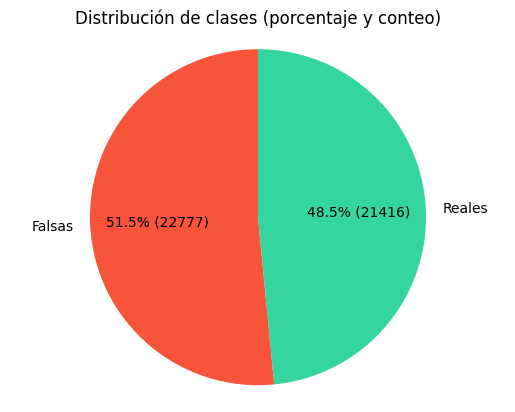

In [9]:
labels = ['Falsas', 'Reales']
counts = [22777, 21416]
percent = [count / sum(counts) * 100 for count in counts]
# Colores aesthetic, suaves pero con carácter
colors = ['#f7543a', '#34d59f']  # Terracota suave y azul grisáceo

fig2, ax2 = plt.subplots()
ax2.pie(percent, labels=labels, autopct=lambda p: f'{p:.1f}% ({round(p * sum(counts) / 100)})', startangle=90, colors=colors)
ax2.set_title('Distribución de clases (porcentaje y conteo)')
ax2.axis('equal')
plt.show()


Veamos la longitud media de nuestras noticias tras el preprocesado completo, lo que nos será de utilidad más tarde:

In [65]:
mean_length = df["clean_text"].apply(len).mean()
print("Mean length of clean_text:", mean_length)

Mean length of clean_text: 1656.3348946665762


Información adicional:

Mean length of clean_text: 1656.3348946665762
Maximum length of clean_text: 37034
Minimum length of clean_text: 4


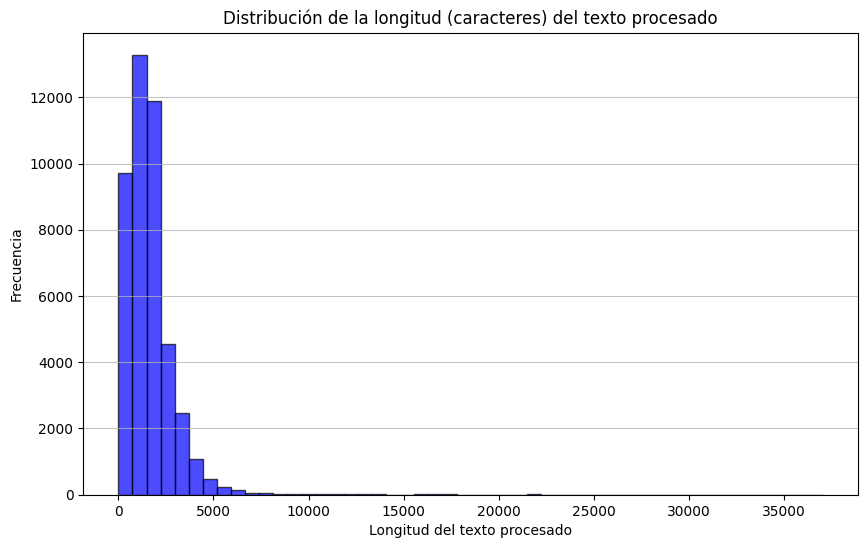

In [14]:
# Calculate the lengths of clean_text
text_lengths = df["clean_text"].apply(len)

# Media de longitud
mean_length = text_lengths.mean()
print("Mean length of clean_text:", mean_length)

# Mínimo y máximo
max_length = text_lengths.max()
min_length = text_lengths.min()
print("Maximum length of clean_text:", max_length)
print("Minimum length of clean_text:", min_length)

# Histograma
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribución de la longitud (caracteres) del texto procesado")
plt.xlabel("Longitud del texto procesado")
plt.ylabel("Frecuencia")
plt.grid(axis='y', alpha=0.75)
plt.show()

Guardamos en un DataFrame todos los datos por si, en un futuro, se necesita utilizarlos.

In [28]:
# Guardar el DataFrame en un archivo CSV
df.to_csv("Datasets/CleanedAllData.csv", index=False)

Guardaremos en otro DataFrame únicamente las columnas procesadas tras la limpieza.
Este DataFrame es el que se utilizará a partir de ahora.

In [29]:
# Eliminar las columnas 'title' y 'text'
df.drop(['title', 'text'], axis=1, inplace=True)

# Mostrar las primeras filas del DataFrame
df.head()

,label,clean_title,clean_text
0,0,whatever happen trump second wife,pretty safe bet press able reveal bad blood do...
1,0,absolute submission trump bow neocon orthodoxy,consortium news exclusive mideast trip saudi a...
2,0,londons mayor harsh word community organizer c...,country spin control obama orchestrate effort ...
4,1,trump top defense homeland official attend mun...,berlin reuter us secretary defense james matti...
5,1,support brazil pension reform organize lawmaker,brasiliario de janeiro reuters government braz...


In [30]:
# Guardar el DataFrame en un archivo CSV
df.to_csv("Datasets/CleanedFakeAndRealNews.csv", index=False)

# Vectorización TF-IDF + Clasificación mediante Random Forest (Caso Reuters)

In [6]:
# Cargar el DataFrame limpio
df = pd.read_csv("../Datasets/CleanedFakeAndRealNews.csv")

# Dividimos los datos en entrenamiento y prueba
# Por ahora usaremos únicamente el texto de la noticia (omitimos el título)
X = df["clean_text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### TF-IDF

In [4]:
# Definimos y utilizamos vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
X_train.shape

(28283, 5000)

El **TfidfVectorizer** genera un shape de (28283, 5000) porque hay 28,283 muestras en el conjunto de entrenamiento, y cada muestra está representada por un **vector de 5,000 características**. Estas 5,000 características corresponden a las palabras más importantes del vocabulario, seleccionadas según su frecuencia en el corpus.

### Random Forest

In [5]:
# Entrenar modelo 
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train) 
 
# Evaluación en test
y_pred = rf.predict(X_test)
print("Precisión:", accuracy_score(y_test, y_pred))

Precisión: 0.9962665459893653


Obtenemos una precisión del 99.5% en test, ¡un valor extremadamente alto!

Apliquemos SHAP para ver qué palabras están afectando a la clasificación (pues es altamente probable que exista alguna palabra condicionando los resultados hacia un lado en muchos casos, lo que explicaría el valor altísimo de *accuracy* obtenido).

### Explicabilidad mediante SHAP

In [6]:
# Es necesario convertir las matrices dispersas a densas
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Aplicamos SHAP
explainer = shap.Explainer(rf, X_train_dense)
shap_values = explainer(X_test_dense)

100%|===================| 17676/17678 [13:59<00:00]        

In [13]:
shap_values.shape

(8839, 5000, 2)

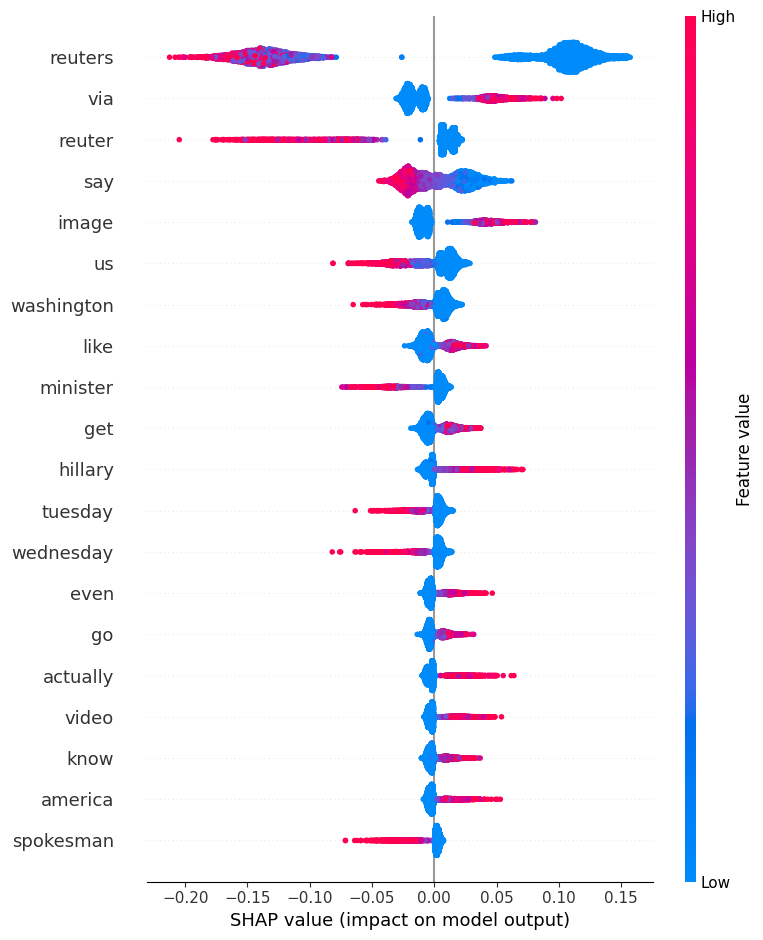

In [ ]:
# Obtenemos las palabras de los vectores TF-IDF
feature_names = vectorizer.get_feature_names_out()

# Elegimos índice a explicar
class_index = 1 # En este caso, ¿qué palabras influyen más y menos en que una noticia sea falsa?

# Seleccionamos los valores SHAP para dicha clase
shap_values_class = shap_values[:, :, class_index]

# Mostrar valores SHAP
shap.summary_plot(shap_values_class, X_test_dense, feature_names=feature_names)

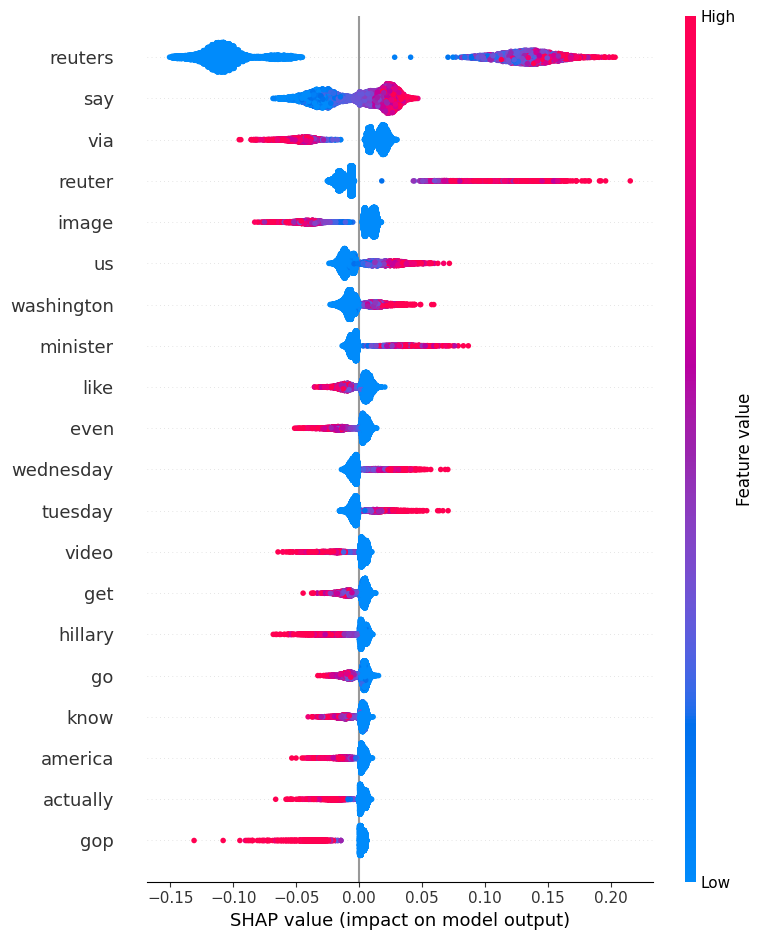

In [7]:
# Obtenemos las palabras de los vectores TF-IDF
feature_names = vectorizer.get_feature_names_out()

# Elegimos índice a explicar
class_index = 1 # En este caso, ¿qué palabras influyen más y menos en que una noticia sea verdadera?

# Seleccionamos los valores SHAP para dicha clase
shap_values_class = shap_values[:, :, class_index]

# Mostrar valores SHAP
shap.summary_plot(shap_values_class, X_test_dense, feature_names=feature_names)

Se puede observar que las palabras *Reuters*, *via* y *Reuter* son las que más influyen en nuestra clasificación.

Concretamente, **Reuters** es una de las fuentes de noticias más confiables a nivel mundial, por lo que el modelo tiende a clasificar como verdadera una noticia que contiene en su texto la marca de la agencia (estas palabras tienen un alto impacto negativo en la clasificación como noticia falsa).

Por otro lado, el uso de la palabra *via* produce el efecto contrario, favoreciendo la clasificación de la noticia como falsa. Exploraremos esto con más detalle a continuación.

El resto de las palabras, como *say*, *image*, *US*, *Washington* o *Minister*, parecen ser más neutras a simple vista.

In [7]:
# Dividimos el DataFrame en verdadero y falso
df_real = df[df['label'] == 1]['clean_text']
df_fake = df[df['label'] == 0]['clean_text']

In [8]:
print("------------------------------------------------------")
count_reuters = sum(1 for text in df_real if "reuters" in text)
print("Number of texts containing the word 'reuters' in REAL DataFrame:", count_reuters)
count_reuters = sum(1 for text in df_fake if "reuters" in text)
print("Number of texts containing the word 'reuters' in FAKE DataFrame:", count_reuters)
print("------------------------------------------------------")
count_via = sum(1 for text in df_real if "via" in text)
print("Number of texts containing the word 'via' in REAL DataFrame:", count_via)
count_via = sum(1 for text in df_fake if "via" in text)
print("Number of texts containing the word 'via' in FAKE DataFrame:", count_via)
print("------------------------------------------------------")
count_reuter = sum(1 for text in df_real if "reuter" in text)
print("Number of texts containing the word 'reuter' in REAL DataFrame:", count_reuter)
count_reuter = sum(1 for text in df_fake if "reuter" in text)
print("Number of texts containing the word 'reuter' in FAKE DataFrame:", count_reuter)
print("------------------------------------------------------")
count_say = sum(1 for text in df_real if "say" in text)
print("Number of texts containing the word 'say' in REAL DataFrame:", count_say)
count_say = sum(1 for text in df_fake if "say" in text)
print("Number of texts containing the word 'say' in FAKE DataFrame:", count_say)

------------------------------------------------------
Number of texts containing the word 'reuters' in REAL DataFrame: 18767
Number of texts containing the word 'reuters' in FAKE DataFrame: 180
------------------------------------------------------
Number of texts containing the word 'via' in REAL DataFrame: 1116
Number of texts containing the word 'via' in FAKE DataFrame: 11447
------------------------------------------------------
Number of texts containing the word 'reuter' in REAL DataFrame: 21378
Number of texts containing the word 'reuter' in FAKE DataFrame: 318
------------------------------------------------------
Number of texts containing the word 'say' in REAL DataFrame: 20453
Number of texts containing the word 'say' in FAKE DataFrame: 16472


In [43]:
# Search for sentences with the word "via" in them
sentences_with_via = [text for text in X if "via" in text][:5]

# Print the sentences
for sentence in sentences_with_via:
    print(sentence)

country spin control obama orchestrate effort race baiter like al sharpton leader black life matter terrorist create divide race like generation never know obama skips supreme court justice anton scalia funeral funeral iconic first lady nancy reagan find time take pot shot gop presidential frontrunner donald trump attend hipster festival michelle barack prove time desire behave like leader go tell european need relate eu hear baron today current president planning go britain make case public stay european union momentarily stun happen lead behind let country handle affairsby jade president nothing free nothing eventual payoff sticking nose britain affairs come surprise give track record last interminable year time officeor maybe know deeply dislike anyone sign onto pathetic peace prize back beginning reign maybe believe sycophantic press tell wait use kind reverse psychology british ie know much hold contempt anything suggest would oppose nah far remove reality grasp conceptso london m

Acabamos de observar cómo:
- La palabra *Reuters* aparece en aproximadamente un **88%** del DataFrame de noticias **reales** y tan sólo en un **0.8%** del DataFrame de noticias **falsas**.
- La palabra *Reuter* aparece en aproximadamente un **99.8%** del DataFrame de noticias **reales** y tan sólo en un **1.4%** del DataFrame de noticias **falsas**.
- Aunque la diferencia se reduce, la palabra *via* aparece en solo un **5.2%** del DataFrame de noticias **reales**, mientras que está presente en un **50.2%** del DataFrame de noticias **falsas**. Además, al analizar ejemplos de frases que contienen esta palabra, se observa que suelen hacer referencia a fuentes de información que podrían percibirse como menos confiables que Reuters o incluso inventadas, como *via WhiteRabbitRadio.net*, via NY Post, *via Politistick* o *via White House*.
- La palabra *say* aparece en la mayoría de noticias, tanto verdaderas como falsas.

Dado que el Dataset original de noticias reales podría provenir de **Reuters**, se eliminarán las palabras *Reuter*/*Reuters* de los textos para evitar que influyan excesivamente en la clasificación.

Sin embargo, otras palabras más neutrales, como *via*, así como las identificadas en el análisis con **SHAP**, incluidas diversas *fuentes de información*, se mantendrán. 

El objetivo es que el modelo aprenda a identificar relaciones más complejas entre palabras para determinar si una noticia es real o falsa, en lugar de basarse únicamente en la mención de un medio confiable. Por ello, repetiremos el experimento tras la eliminación.

# Vectorización TF-IDF + Clasificación mediante Random Forest

## Entrenamiento, test y explicabilidad

In [ ]:
df = pd.read_csv("Datasets/CleanedFakeAndRealNews.csv")
# Eliminar la palabra "reuter" y "reuters" de los textos
df["clean_text"] = df["clean_text"].str.replace(r"\b(reuter|reuters)\b", "", regex=True)
df.shape # Mantenemos el mismo número de filas

(44193, 3)

In [8]:
df = pd.read_csv("../Datasets/Cleaned-FR-News_V2.csv")
# Dividimos los datos en entrenamiento y prueba
X = df["clean_text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definimos y utilizamos vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # 5000 palabras más importantes (ordenadas por frecuencia de aparición en el corpus)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# pd.to_pickle(vectorizer, "models/tf-idf-vectorizer.pkl")

In [9]:
# Dividimos los datos en entrenamiento y prueba
X = df["clean_text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definimos y utilizamos vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # 5000 palabras más importantes (ordenadas por frecuencia de aparición en el corpus)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Entrenar modelo 
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train) 
 
# Evaluación en test
y_pred = rf.predict(X_test)
print("Precisión:", accuracy_score(y_test, y_pred))

Precisión: 0.982011539766942


La precisión ha bajado únicamente un 1%, lo cual sigue siendo un resultado muy bueno (**98,2%** en test). Veamos la explicabilidad con SHAP de nuevo.

100%|===================| 17670/17678 [17:16<00:00]        

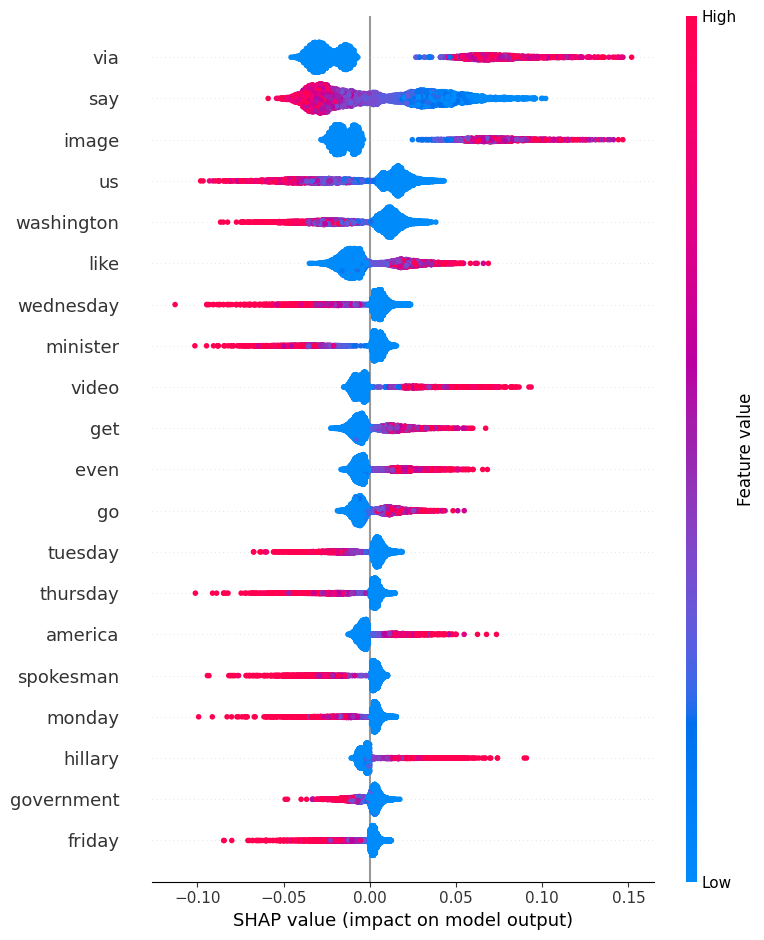

In [49]:
# Es necesario convertir las matrices dispersas a densas
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Aplicamos SHAP
explainer = shap.Explainer(rf, X_train_dense)
shap_values = explainer(X_test_dense)

# Obtenemos las palabras de los vectores TF-IDF
feature_names = vectorizer.get_feature_names_out()

# Elegimos índice a explicar
class_index = 0 # En este caso, ¿qué palabras influyen más y menos en que una noticia sea falsa?

# Seleccionamos los valores SHAP para dicha clase
shap_values_class = shap_values[:, :, class_index]

# Mostrar valores SHAP
shap.summary_plot(shap_values_class, X_test_dense, feature_names=feature_names)

100%|===================| 17667/17678 [17:39<00:00]        

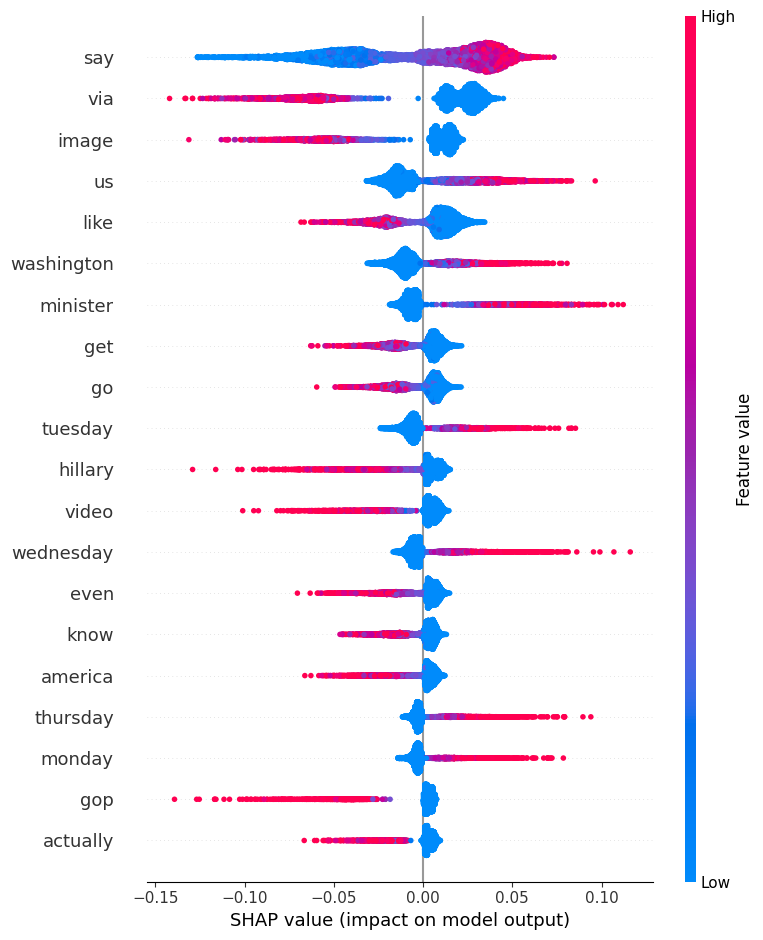

In [10]:
# Es necesario convertir las matrices dispersas a densas
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Aplicamos SHAP
explainer = shap.Explainer(rf, X_train_dense)
shap_values = explainer(X_test_dense)

# Obtenemos las palabras de los vectores TF-IDF
feature_names = vectorizer.get_feature_names_out()

# Elegimos índice a explicar
class_index = 1 # En este caso, ¿qué palabras influyen más y menos en que una noticia sea verdadera?

# Seleccionamos los valores SHAP para dicha clase
shap_values_class = shap_values[:, :, class_index]

# Mostrar valores SHAP
shap.summary_plot(shap_values_class, X_test_dense, feature_names=feature_names)

A continuación, se describe por qué cada palabra podría influir en la clasificación de la noticia como Fake o Real según se observa en el gráfico SHAP:

1. **via**  
   - *Motivo*: Puede emplearse para aparentar referencias externas sin verificación real, **incrementando la probabilidad de ser Fake**.

2. **say**  
   - *Motivo*: Alude a declaraciones directas que, si están respaldadas por fuentes confiables, **reducen la sospecha** de información falsa.

3. **image**  
   - *Motivo*: Hace referencia a imágenes que pueden ser manipuladas o sacadas de contexto, incrementando la **posibilidad de desinformación**.

4. **us**  
   - *Motivo*: Al referirse a Estados Unidos, suele haber más cobertura mediática y verificación, lo que **baja la probabilidad** de que la noticia sea Fake.

5. **washington**  
   - *Motivo*: Asociado a la política y prensa formal de EE. UU., a menudo ofrece fuentes oficiales, **reduciendo la posibilidad** de ser Fake.

6. **like**  
   - *Motivo*: Uso informal que puede denotar lenguaje sensacionalista, lo cual tiende a **elevar la probabilidad** de ser Fake.

7. **wednesday**  
   - *Motivo*: Al mencionar un día específico, suele asociarse con noticias formales y verificadas, **reduciendo la sospecha** de ser Fake.

8. **minister**  
   - *Motivo*:  Implica una fuente oficial o gubernamental, lo que habitualmente está ligado a noticias más **verídicas**.

9. **video**  
   - *Motivo*: La mención de videos puede implicar contenido potencialmente manipulado o editado, **aumentando la desconfianza**.  

10. **get**  
    - *Motivo*: Verbo usado a menudo en titulares sensacionalistas o vagos, lo cual **eleva la probabilidad** de ser Fake.  

11. **even**  
    - *Motivo*: Suele aportar énfasis o dramatismo en el discurso, factor que puede incrementar la percepción de **contenido engañoso**.  

12. **go**  
    - *Motivo*: Palabra de acción que puede relacionarse con llamados a actuar de manera apresurada o **sensacionalista**.  

13. **tuesday**  
    - *Motivo*:  Al mencionar un día específico, suele asociarse con noticias formales y verificadas, **reduciendo la sospecha** de ser Fake.

14. **thursday**  
    - *Motivo*:  Al mencionar un día específico, suele asociarse con noticias formales y verificadas, **reduciendo la sospecha** de ser Fake.

15. **america**  
    - *Motivo*: Vincula el contenido con **asuntos geopolíticos**, un terreno fértil para la proliferación de noticias falsas.  

16. **spokesman**  
    - *Motivo*: Hace referencia a una fuente oficial que suele **dotar de credibilidad** al texto, reduciendo la sospecha de Fake.  

17. **monday**  
    - *Motivo*: Al mencionar un día específico, suele asociarse con noticias formales y verificadas, **reduciendo la sospecha** de ser Fake.

18. **hillary**  
    - *Motivo*: Involucra a una figura política relevante, frecuentemente **asociada a controversias** y, por ende, a posibles Fake News.  

19. **government**  
    - *Motivo*: Mencionar al gobierno puede implicar declaraciones oficiales o controversias políticas, un **foco común de desinformación**.  

20. **friday**  
    - *Motivo*: Al mencionar un día específico, suele asociarse con noticias formales y verificadas, **reduciendo la sospecha** de ser Fake.


Es particularmente notable que, de las 20 palabras con mayor impacto en la clasificación, 5 corresponden a días de la semana, representando así el 25% del total. 

Verificaremos que no se trate de un formato típico de Reuters para confirmar que la mención del día de la semana efectivamente aporta credibilidad y suele mencionarse en noticias reales.

In [6]:
# Buscar frases con la palabra "monday"
sentences_with_monday = [text for text in df["clean_text"] if "monday" in text][:5]

# Imprimir las frases
for sentence in sentences_with_monday:
    print(sentence)

brasiliario de janeiro  government brazil president michel temer far assemble coalition need pass landmark pension reform potential supporter measure organize key legislator say monday still enormously far need vote party leader commit party president commit one party set commit brazil low house speaker rodrigo maia tell journalist event rio de janeiro pension reform cornerstone policy president temer effort bring brazil deficit control measure widely unpopular brazilian accustom relatively expansive welfare net order curry support congress temer ally water original proposal november require few year contribution private sector worker receive pension accord several government source temer ally grow optimistic last week reform chance however speed essential bill passage congressional recess begin dec lawmaking thereafter hamper politic lawmaker ramp campaign election
london  foreign minister boris johnson say britain would appeal iran humanitarian ground free jail aid worker express res

In [7]:
# Dividimos el DataFrame en verdadero y falso
df_real = df[df['label'] == 1]['clean_text']
df_fake = df[df['label'] == 0]['clean_text']

# Días de la semana
days_of_week = ["monday", "tuesday", "wednesday", "thursday", "friday"]

# Contar ocurrencias en df_real
print("Ocurrencias en df_real:")
for day in days_of_week:
    count = sum(1 for text in df_real if day in text)
    print(f"{day.capitalize()}: {count}")

# Contar ocurrencias en df_fake
print("\nOcurrencias en df_fake:")
for day in days_of_week:
    count = sum(1 for text in df_fake if day in text)
    print(f"{day.capitalize()}: {count}")

Ocurrencias en df_real:
Monday: 4887
Tuesday: 5672
Wednesday: 5593
Thursday: 5341
Friday: 4983

Ocurrencias en df_fake:
Monday: 1877
Tuesday: 1987
Wednesday: 1795
Thursday: 1744
Friday: 1914


Se evidencia una mayor presencia de los días de la semana en las noticias reales en comparación con las falsas. Sin embargo, esta diferencia no es tan pronunciada como en el caso de Reuters, lo que sugiere que nuestro modelo ha capturado relaciones más complejas para realizar su clasificación de manera efectiva.

In [ ]:
df.to_csv("Datasets/Cleaned-FR-News_V2.csv", index=False)

## Grid Search y Cross Validation

En este apartado, incluiremos dos aspectos adicionales para mejorar la evaluación y optimización del modelo:

- **Grid Search**: Para explorar diferentes combinaciones de hiperparámetros y verificar si es posible mejorar el rendimiento del modelo mediante una configuración más óptima.

- **Cross Validation**: Para obtener una estimación más robusta del desempeño del modelo, calculando la media de evaluación a través de múltiples particiones de los datos. De esta manera, evitaremos basarnos únicamente en el resultado del conjunto de prueba. Esto se realiza al mismo tiempo que se exploran las diferentes combinaciones del Grid Search.

In [ ]:
# Definir el rango de hiperparámetros para el Grid Search
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500], # Nos interesa principalmente el número de árboles
    # El resto de hiperparámetros en *default* presentan un buen rendimiento, por lo que no los modificamos para ahorrar tiempo de entrenamiento.
}

# Crear un nuevo RandomForestClassifier para el Grid Search
rf_grid = RandomForestClassifier(random_state=42)

# Configurar el Grid Search
grid_search = GridSearchCV(estimator=rf_grid, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Ejecutar el Grid Search
grid_search.fit(X_train, y_train) 

# Guardar los resultados en una lista
results = grid_search.cv_results_
n_estimators = param_grid['n_estimators']
mean_accuracies = results['mean_test_score']

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores hiperparámetros: {'n_estimators': 500}
Mejor puntuación de validación cruzada: 0.9805963117676699


Dado que el mejor desempeño se obtuvo con el mayor número de estimadores evaluado, ampliaremos el rango de búsqueda agregando dos valores adicionales: *n_estimators=750* y *n_estimators=1000*.

Sin embargo, según la teoría de los árboles de decisión, es probable que la precisión ya haya alcanzado un punto de estabilización alrededor de estos valores. A partir de cierto umbral, aumentar la cantidad de estimadores suele tener un impacto marginal en el rendimiento, ya que el modelo tiende a converger. No obstante, realizar esta prueba nos permitirá confirmar si aún es posible obtener mejoras significativas o si hemos alcanzado el punto óptimo de complejidad del modelo.

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Mejores hiperparámetros (rango extendido): {'n_estimators': 1000}
Mejor puntuación de validación cruzada (rango extendido): 0.9814165755020255


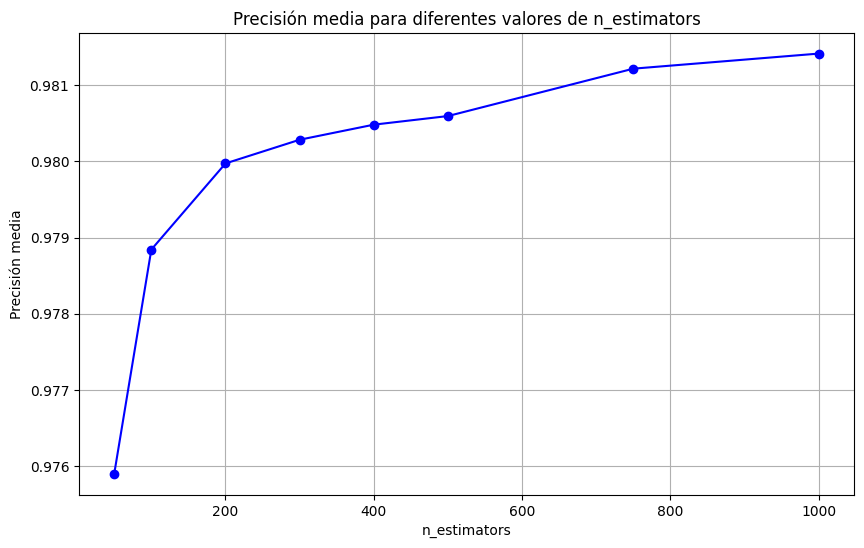

In [9]:
# Ampliar el rango de búsqueda de hiperparámetros
param_grid_extended = {
    'n_estimators': [750, 1000],  # Agregar 750 y 1000
}

# Configurar el Grid Search con el rango extendido
grid_search_extended = GridSearchCV(estimator=rf_grid, param_grid=param_grid_extended, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Ejecutar el Grid Search con el rango extendido
grid_search_extended.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros y la mejor puntuación
print("Mejores hiperparámetros (rango extendido):", grid_search_extended.best_params_)
print("Mejor puntuación de validación cruzada (rango extendido):", grid_search_extended.best_score_)

# Unir los valores de n_estimators y las precisiones medias
n_estimators = n_estimators + param_grid_extended['n_estimators']
mean_accuracies = list(mean_accuracies) + list(grid_search_extended.cv_results_['mean_test_score'])

# Graficar las diferentes precisiones
plt.figure(figsize=(10, 6))
plt.plot(n_estimators, mean_accuracies, marker='o', linestyle='-', color='b')
plt.title('Precisión media para diferentes valores de n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Precisión media')
plt.grid(True)
plt.show()

El modelo con 200 árboles presenta una diferencia de solo 0.001 en precisión respecto al de 1000 árboles. Esto indica que la convergencia ocurre alrededor de 100-200 estimadores, alcanzando así la precisión óptima.

In [5]:
# Validación cruzada con 10 particiones y 200 estimadores
rf_cv = RandomForestClassifier(n_estimators=200, random_state=42)
cv_scores = cross_val_score(rf_cv, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)

# Mostrar resultados de la validación cruzada
print("Precisión media en validación cruzada (10 folds):", np.mean(cv_scores))

Precisión media en validación cruzada (10 folds): 0.9820105266021107


In [22]:
# Entrenar el modelo con todo el conjunto de entrenamiento
rf_cv.fit(X_train, y_train)

# Evaluación en el conjunto de prueba
y_pred_test = rf_cv.predict(X_test)
print("Precisión en el conjunto de prueba:", accuracy_score(y_test, y_pred_test))

Precisión en el conjunto de prueba: 0.9837085643172304


Guardamos el mejor modelo de Random Forest, con una precisión en el conjunto de prueba de un **98.37%**.

In [10]:
# Guardar el modelo
with open('models/best_rf.pkl', 'wb') as f:
    pickle.dump(rf_cv, f)

Resumen de evaluación cargando el mejor modelo:

In [8]:
# Cargar el modelo desde el archivo
with open('../models/best_rf.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Verificar el modelo cargado
print(loaded_model)

RandomForestClassifier(n_estimators=200, random_state=42)


In [ ]:
from sklearn.metrics import roc_auc_score, recall_score, f1_score
from sklearn.metrics import precision_score

# Evaluación en el conjunto de prueba
y_pred_test = loaded_model.predict(X_test)
print("Exactitud (accuracy) en el conjunto de prueba:", accuracy_score(y_test, y_pred_test))

# Calcular Precisión
precision = precision_score(y_test, y_pred_test)
print("Precisión:", precision)

# Calcular Recall
recall = recall_score(y_test, y_pred_test)
print("Recall:", recall)

# Calcular F1 Score
f1 = f1_score(y_test, y_pred_test)
print("F1 Score:", f1)

# Calcular AUC ROC
auc_roc = roc_auc_score(y_test, y_pred_test)
print("AUC ROC:", auc_roc)

Precisión en el conjunto de prueba: 0.9837085643172304
Precisión: 0.9829239766081871
Recall: 0.9833840393166393
F1 Score: 0.9831539541413196
AUC ROC: 0.9836981519404046


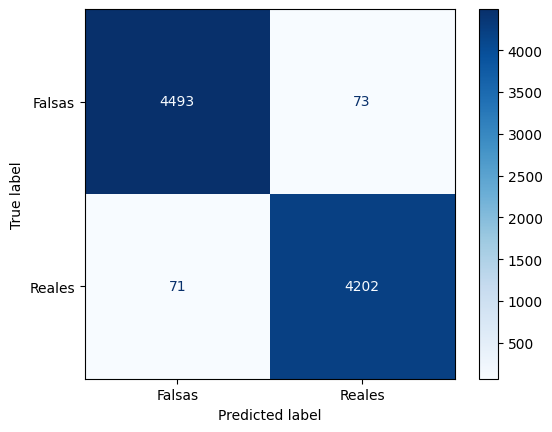

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Falsas", "Reales"])
disp.plot(cmap=plt.cm.Blues)
plt.show()